In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [ ]:
data_path = '/content/MergedData.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

In [ ]:
# covert times
def convert_to_seconds(t):
    if ':' in t:
        m, s = t.split(':')
        return int(m) * 60 + float(s)
    return float(t)

data['Time_in_seconds'] = data['Time'].apply(convert_to_seconds)

In [ ]:
data[['Month', 'Day', 'Year']] = data['Date'].str.split('/', expand=True)
data['Month'] = data['Month'].astype(int)
data['Day'] = data['Day'].astype(int)
data['Year'] = data['Year'].astype(int)

In [ ]:
# scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data['Month_scaled'] = scaler.fit_transform(data['Month'].values.reshape(-1, 1))

In [ ]:
# filter data
jason_data = data[(data['Name'] == 'Jason Kim') & (data['Event'] == '100 FR SCY Male')].sort_values(by='Date', ascending=True)
bryce_data = data[(data['Name'] == 'Bryce Grover') & (data['Event'] == '100 FR SCY Male')].sort_values(by='Date', ascending=True)

In [ ]:
sequence_length = 2

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    if len(data) >= sequence_length:
        for i in range(len(data) - sequence_length):
            X.append(data['Month_scaled'].values[i:i+sequence_length])
            y.append(data['Month_scaled'].values[i+sequence_length])
    return np.array(X), np.array(y)

X_jason, y_jason = create_sequences(jason_data, sequence_length)
X_bryce, y_bryce = create_sequences(bryce_data, sequence_length)

In [ ]:
print("X_jason shape:", X_jason.shape)
print("X_bryce shape:", X_bryce.shape)

X_jason shape: (71, 5)
X_bryce shape: (10, 5)


In [ ]:
# combine into one
X = np.concatenate([X_jason, X_bryce], axis=0)
y = np.concatenate([y_jason, y_bryce], axis=0)
X = X.reshape(X.shape[0], sequence_length, 1)

In [ ]:
# tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [ ]:
# model architecture
model = Sequential([
    LSTM(64, input_shape=(sequence_length, 1), activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [ ]:
# train
history = model.fit(X_train, y_train, epochs=300, validation_split=0.1, batch_size=16, callbacks=[early_stopping], verbose=0)

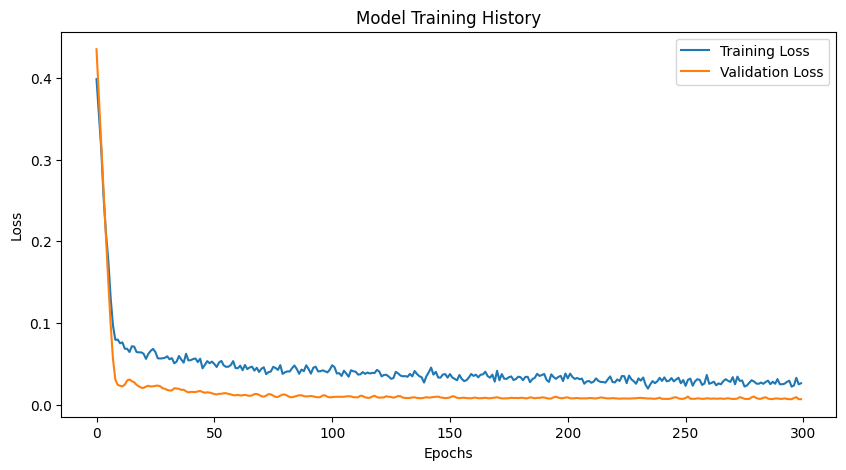

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

In [ ]:
# predict best month
def predict_best_month(data, sequence_length):
    scaled_sequence = scaler.transform(data['Month'].values[-sequence_length:].reshape(-1, 1)).reshape(1, sequence_length, 1)
    predicted_month = model.predict(scaled_sequence)
    return scaler.inverse_transform(predicted_month).flatten()[0]

predicted_month_jason = predict_best_month(jason_data, sequence_length)
predicted_month_bryce = predict_best_month(bryce_data, sequence_length)

1/1 [==============================] - 0s 31ms/step


In [ ]:
print("Predicted Month for Jason:", predicted_month_jason, "month")
print("Predicted Month for Bryce:", predicted_month_bryce, "month")

Predicted Month for Jason Kim: 9.234737 month
Predicted Month for Bryce Grover: 8.815543 month


In [ ]:
df_jason = jason_data[['Month', 'Time_in_seconds', 'Year']]
df_bryce = bryce_data[['Month', 'Time_in_seconds', 'Year']]

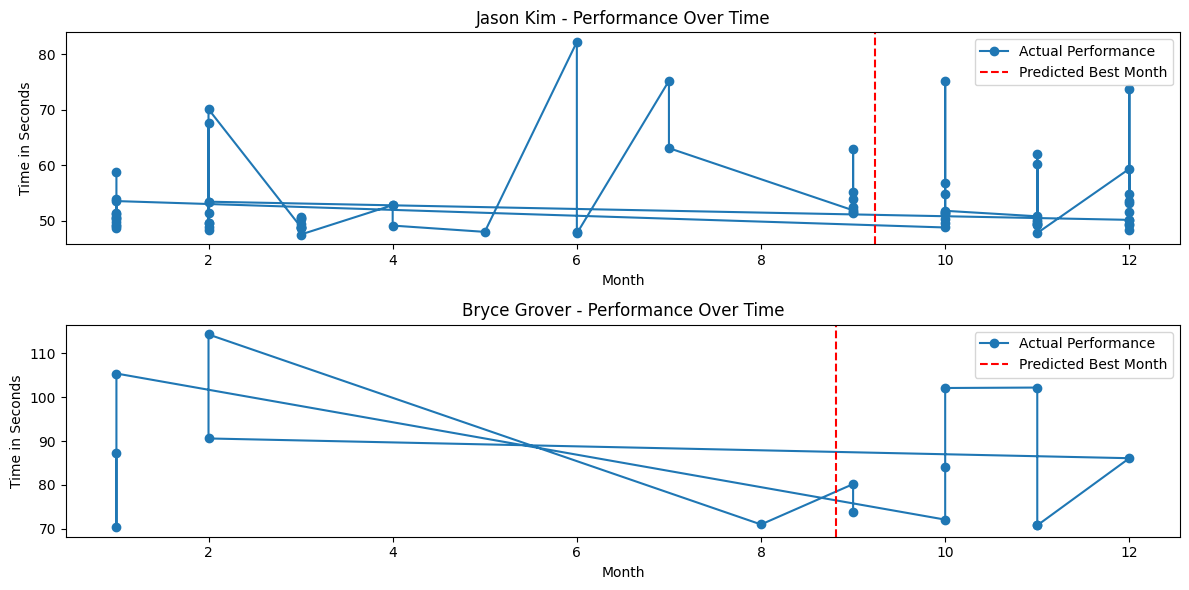

In [ ]:
plt.figure(figsize=(12, 6))

# jason plot
plt.subplot(2, 1, 1)
plt.plot(df_jason['Month'], df_jason['Time_in_seconds'], marker='o', label='Actual Performance')
plt.axvline(x=predicted_month_jason, color='r', linestyle='--', label='Predicted Best Month')
plt.title('Jason Kim - Performance Over Time')
plt.xlabel('Month')
plt.ylabel('Time in Seconds')
plt.legend()

# bryce plot
plt.subplot(2, 1, 2)
plt.plot(df_bryce['Month'], df_bryce['Time_in_seconds'], marker='o', label='Actual Performance')
plt.axvline(x=predicted_month_bryce, color='r', linestyle='--', label='Predicted Best Month')
plt.title('Bryce Grover - Performance Over Time')
plt.xlabel('Month')
plt.ylabel('Time in Seconds')
plt.legend()

plt.tight_layout()
plt.show()

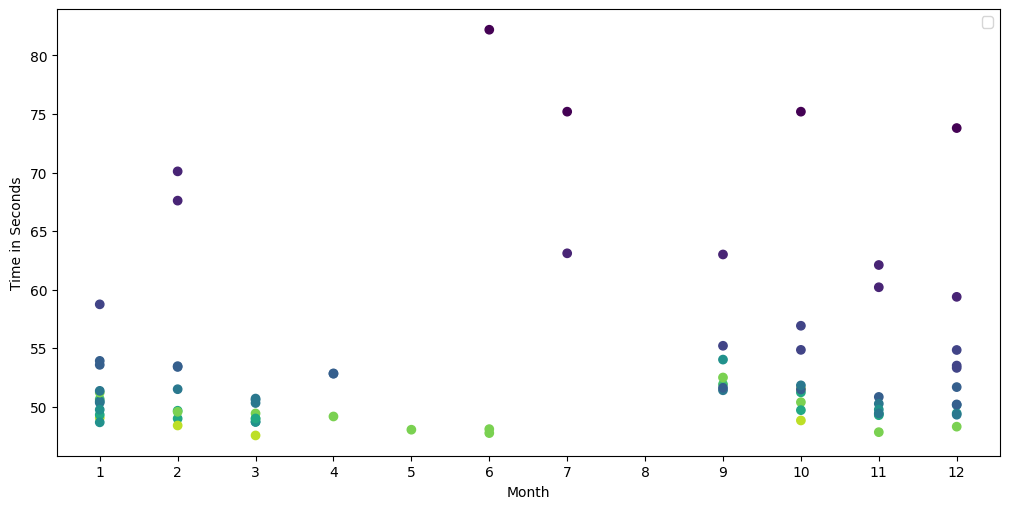

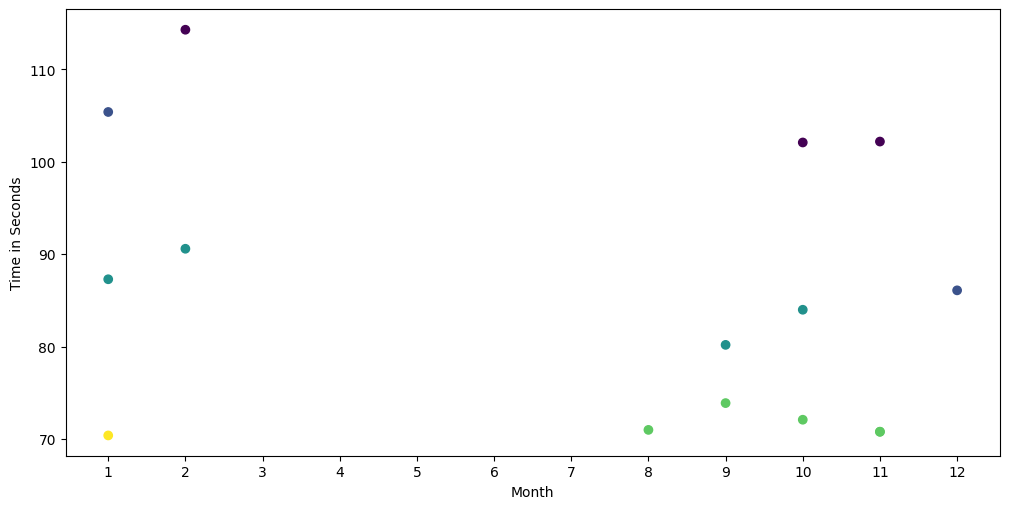

In [ ]:
df_jason = jason_data[['Month','Time_in_seconds', 'Year']]
df_bryce = bryce_data[['Month','Time_in_seconds', 'Year']]

plt.figure(figsize=(10,5))
plt.scatter(df_jason['Month'], df_jason['Time_in_seconds'], c=df_jason['Year'])
plt.tight_layout()
plt.ylabel('Time in Seconds')
plt.xlabel('Month')
plt.xticks([1, 2, 3, 4, 5,6,7,8,9,10,11,12])
plt.legend()
plt.show();

plt.figure(figsize=(10,5))
plt.scatter(df_bryce['Month'], df_bryce['Time_in_seconds'], c=df_bryce['Year'])
plt.tight_layout()
plt.ylabel('Time in Seconds')
plt.xlabel('Month')
plt.xticks([1, 2, 3, 4, 5,6,7,8,9,10,11,12])
plt.show();